<a href="https://colab.research.google.com/github/Gaci-git/loan_club/blob/main/Loan_Club.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loan Club Machine Learning prediction using XGBoost, Optuna and Streamlit

Being able to accurately assess the risk of a loan application can save a lender the cost of holding too many risky assets.

Without having a credit score or credit history we will try to predict how profitable a loan will be compared to our loans database, accumulated over the years. 

* The first step of our plan is to create a machine learning model to classify loans into paid/charged off* so that we can start learning if you have enough data to solve this simple problem adequately. 

* The second step is to predict the grade for the loan

*  The third step is to predict the subgrade and the interest rate.

* and finally, deploy a fully-working deployed model that your company can use. Excitedly you get to work!


** A charge-off is a debt, for example on a credit card, that is deemed unlikely to be collected by the creditor because the borrower has become substantially delinquent after a period of time. However, a charge-off does not mean a write-off of the debt entirely. Having a charge-off can mean serious repercussions on your credit history and future borrowing ability.

# Column meaning

* **loan_amnt** The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
* **term**  The number of payments on the loan. Values are in months and can be either 36 or 60.
* **int_rate**  Interest Rate on the loan
* **installment** The monthly payment owed by the borrower if the loan originates.
* **grade** LC assigned loan grade
* **sub_grade** LC assigned loan subgrade
* **emp_length**  Employment length in years. Possible values are between 0 and * 10 where 0 means less than one year and 10 means ten or more years.
* **home_ownership**  The homeownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER
* **annual_inc**  The self-reported annual income provided by the borrower during registration.
* **verification_status** Indicates if income was verified by LC, not verified, or if the income source was verified
* **issue_d** The month in which the loan was funded
* **loan_status** Current status of the loan
* **purpose** A category provided by the borrower for the loan request.
* **title** The loan title provided by the borrower
* **zip_code**  The first 3 numbers of the zip code provided by the borrower in the loan application.
* **addr_state**  The state provided by the borrower in the loan application
* **dti** A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
* **earliest_cr_line**  The month the borrower's earliest reported credit line was opened
* **open_acc**  The number of open credit lines in the borrower's credit file.
* **pub_rec** Number of derogatory public records
* **revol_bal** Total credit revolving balance
* **revol_util**  Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
* **total_acc** The total number of credit lines currently in the borrower's credit file
* **initial_list_status** The initial listing status of the loan. Possible values are – W, F
* **application_type**  Indicates whether the loan is an individual application or a joint application with two co-borrowers
* **mort_acc**  Number of mortgage accounts.
* **pub_rec_bankruptcies**  Number of public record bankruptcies

# Imports

In [ ]:
!pip install pyspark
from pyspark import SparkContext                                    
from pyspark.sql import SparkSession, Window, Row                   
from pyspark.sql import functions                                 
from pyspark.sql.functions import *                                
from pyspark.sql.types import *    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 40 kB/s 
     |████████████████████████████████| 199 kB 11.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845514 sha256=e85727348940934eeef42c043cb5007e021c5bd8b79fea870f7b55a115c17c6c
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


In [3]:
import numpy as np                              
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.express as px                                   
import seaborn as sns                                               
import pandas as pd                                         
from pyspark.ml.feature import VectorAssembler                      
import warnings                                                     
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats   
from sklearn.model_selection import train_test_split  
from imblearn.combine import SMOTETomek
from sklearn.model_selection import GridSearchCV                             

In [4]:
! pip uninstall xgboost
! pip install xgboost==1.6.2
import xgboost
xgboost.__version__

Found existing installation: xgboost 1.6.2
Uninstalling xgboost-1.6.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/xgboost-1.6.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/xgboost.libs/libgomp-a34b3233.so.1.0.0
    /usr/local/lib/python3.7/dist-packages/xgboost/*
Proceed (y/n)? n
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'1.6.2'

In [ ]:
!pip install shap
import shap

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
def plot_bar(dataframe, column_name):
  df1 = pd.DataFrame(dataframe, columns=[column_name, 'loan_status'])

  df_2 = df1.groupby([column_name, 'loan_status']).size().reset_index()
  df_2['percentage'] = dataframe.groupby([column_name, 'loan_status']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).values
  df_2.columns = [column_name, 'loan_status', 'Counts', 'Percentage']

  fig = px.bar(df_2, 
              x= column_name, 
              y=['Counts'], 
              color='loan_status', 
              color_continuous_scale=px.colors.diverging.Portland,
              text=df_2['Percentage'].apply(lambda x: '{0:1.2f}%'.format(x)))
  fig.update_coloraxes(showscale=False)

  fig.update_layout(
    autosize=False,
    width=1000,
    height=700)

  fig.show()


def plot_kde(column_name):
  str_only = df[df['loan_status'] == "Charged Off"]
  no_str_only = df[df['loan_status'] == "Fully Paid"]
  
  fig = plt.figure(figsize=(14,10))
  ax = fig.add_subplot()


  positive = pd.DataFrame(str_only[column_name])
  negative = pd.DataFrame(no_str_only[column_name])
  sns.kdeplot(positive[column_name], ax=ax,color="#0f4c81", shade=True, ec='black',label="Charged Off")
  sns.kdeplot(negative[column_name], ax=ax, color="#9bb7d4", shade=True, ec='black',label="Fully Paid")

  plt.ticklabel_format(style='plain')
  ax.yaxis.set_major_locator(mtick.MultipleLocator(2))
  ax.xaxis.set_minor_formatter(mtick.ScalarFormatter())
  ax.set_ylabel('')    
  ax.set_xlabel('')
  ax.legend()
  plt.show()


def draw_box_plot(dataframe):
  number = 0
  fig, ax = plt.subplots(1, 10, figsize=(24, 12))
  plt.subplots_adjust(wspace=1) 

  for column_name in column_names:
    sns.boxplot(data=df[column_name], ax=ax[number], palette = 'Blues')
    ax[number].set_xlabel(column_name)
    number += 1

  for subplot in ax:
    subplot.set_xticklabels([])
  plt.show()


## Imports for XGBoost

In [7]:
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, auc,precision_score
from sklearn.model_selection import cross_val_score
from imblearn.combine import SMOTETomek

In [8]:
!pip install optuna
import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
def evaluation(prediction):
  print("\n R-Squared : ", r2_score(y_val, prediction) * 100)
  print('\n ROC AUC Score : ', roc_auc_score(y_val, prediction))
  print("\n Model Accuracy : ",metrics.accuracy_score(y_val, prediction))
  print(classification_report(y_val, prediction))

In [10]:
def evaluation_multi(prediction):
  print("\n R-Squared : ", r2_score(y_val, prediction) * 100)
  print('\n ROC AUC Score : ', roc_auc_score(y_val, fitted_model.predict_proba(X_val), multi_class="ovr"))
  print("\n Model Accuracy : ",metrics.accuracy_score(y_val, prediction))
  print(classification_report(y_val, prediction))

In [11]:
def classification_multi(trial):

  param = {
      "verbosity": 0,  # 0 (silent) - 3 (debug)
      "objective": "binary:logistic",
      "tree_method": "exact",
      "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
      "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
      "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
      "subsample": trial.suggest_float("subsample", 0.2, 1.0),
      "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
  }

  if param["booster"] in ["gbtree", "dart"]:
    param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
    param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
    param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
    param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

  if param["booster"] == "dart":
    param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
    param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
    param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
    param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

  

  model = XGBClassifier(random_state=42, **param)
  model.fit(X_train,y_train, eval_set=[(X_val,y_val)],verbose=False)

  predicted_values = model.predict(X_val)
  roc_auc_score1= roc_auc_score(y_val, model.predict_proba(X_val), multi_class="ovr")
  return roc_auc_score1

In [12]:
def classification(trial):

  param = {
      "verbosity": 0,  # 0 (silent) - 3 (debug)
      "objective": "binary:logistic",
      "tree_method": "exact",
      "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
      "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
      "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
      "subsample": trial.suggest_float("subsample", 0.2, 1.0),
      "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
  }

  if param["booster"] in ["gbtree", "dart"]:
    param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
    param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
    param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
    param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

  if param["booster"] == "dart":
    param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
    param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
    param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
    param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

  

  model = XGBClassifier(random_state=42, **param)
  model.fit(X_train,y_train, eval_set=[(X_val,y_val)],verbose=False)

  predicted_values = model.predict(X_val)
  roc_auc_score1 = roc_auc_score(y_val, predicted_values)
  return roc_auc_score1

# Managing data with PySpark

In [ ]:
!unzip "/content/drive/My Drive/lending-club.zip"

Archive:  /content/drive/My Drive/lending-club.zip
  inflating: accepted_2007_to_2018Q4.csv.gz  
  inflating: accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv  
  inflating: rejected_2007_to_2018Q4.csv.gz  
  inflating: rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv  


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz

In [ ]:
!tar xf spark-3.3.1-bin-hadoop3.tgz

In [ ]:
import os
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.3.1-bin-hadoop3'

In [ ]:
# Install library for finding Spark
!pip install -q findspark
# Import the libary
import findspark
# Initiate findspark
findspark.init()
# Check the location for Spark
findspark.find()

'/content/spark-3.3.1-bin-hadoop3'

In [ ]:
# Import SparkSession

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "15g") \
    .appName('loan_club') \
    .getOrCreate()

In [ ]:
accepted = spark.read.csv("accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv", header=True, inferSchema=True)

In [ ]:
accepted.show(10)

+--------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+--------+-----------+----------+--------------------+----+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+---------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------+-------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-

# Cleaning dataframe

We will drop all current loans - not paid yet and not charged off. They would not benefit us yet, as we are interested only in loans that already have an outcome. 

In [ ]:
accepted = accepted.where((accepted.loan_status == 'Fully Paid') | (accepted.loan_status == 'Charged Off'))
accepted = accepted.dropDuplicates()


In [ ]:
columns = ('id', 'loan_amnt','term','int_rate','installment','grade','sub_grade', 'emp_length',
                        'home_ownership','annual_inc','verification_status','issue_d', 'last_pymnt_d','purpose',
                        'dti','earliest_cr_line','open_acc','pub_rec','revol_bal','revol_util',
                        'total_acc','initial_list_status','application_type','mort_acc','pub_rec_bankruptcies', 'loan_status')

accepted = accepted.select(*columns)


In [ ]:
accepted = accepted.na.drop()
accepted.show()

+--------+---------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+--------+------------+------------------+-----+----------------+--------+-------+---------+----------+---------+-------------------+----------------+--------+--------------------+-----------+
|      id|loan_amnt|      term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status| issue_d|last_pymnt_d|           purpose|  dti|earliest_cr_line|open_acc|pub_rec|revol_bal|revol_util|total_acc|initial_list_status|application_type|mort_acc|pub_rec_bankruptcies|loan_status|
+--------+---------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+--------+------------+------------------+-----+----------------+--------+-------+---------+----------+---------+-------------------+----------------+--------+--------------------+-----------+
|68340587|  12000.0| 36 months|    9.17|     382.

## Home_ownership cleanup

There are some values in the home_ownership column that are not quite clear. For example, OTHER, NONE, or ANY. 

Let's drop those rows out and build our model based on clear information, meaning knowing that our customer is either owning or renting their house, or already has a mortgage for it. 

In [ ]:
# home_ownership values
accepted.groupBy('home_ownership').count().orderBy('count').show()

+--------------+------+
|home_ownership| count|
+--------------+------+
|         OTHER|    42|
|          NONE|    43|
|           ANY|   264|
|           OWN|125386|
|          RENT|484456|
|      MORTGAGE|607909|
+--------------+------+



In [ ]:
accepted = accepted.where((accepted.home_ownership == 'MORTGAGE') | (accepted.home_ownership == 'RENT') | (accepted.home_ownership == 'OWN'))

Saving the last 100 000 records to the pandas data frame. 
We only need the newest data for such predictions, as the financial sector is changing very fast.

In [ ]:
sample = accepted.sort('id').limit(100000)

## Saving to pandas 

In [ ]:
#pandas_df = sample.toPandas()

In [ ]:
#pandas_df.to_csv('df.csv')
#!cp df.csv "drive/My Drive/"

# EDA

In [13]:
df = pd.read_csv('/content/drive/My Drive/df.csv', index_col=[0])

In [14]:
df.head()

,id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,loan_status
0,100001133,30000.0,36 months,8.24,943.42,B,B1,10+ years,OWN,132630.0,...,15.0,0.0,3444.0,5.3,22.0,w,Individual,2.0,0.0,Charged Off
1,100001137,7200.0,36 months,28.69,300.51,F,F1,10+ years,MORTGAGE,73000.0,...,9.0,1.0,6501.0,28.8,13.0,f,Individual,0.0,1.0,Fully Paid
2,100001158,7000.0,36 months,11.49,230.80,B,B5,9 years,MORTGAGE,60000.0,...,11.0,0.0,12916.0,54.5,21.0,w,Individual,1.0,0.0,Fully Paid
3,100001163,11200.0,36 months,13.99,382.74,C,C3,3 years,RENT,60000.0,...,18.0,0.0,9686.0,40.9,33.0,f,Individual,0.0,0.0,Charged Off
4,100001282,13200.0,36 months,19.99,490.50,D,D4,3 years,RENT,33000.0,...,10.0,0.0,9790.0,55.0,30.0,f,Individual,0.0,0.0,Charged Off


In [15]:
df = df.drop(columns=['id'])
df.shape

(100000, 25)

## Outliers

In [16]:
column_names = [
 'loan_amnt',
 'installment',
 'annual_inc',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'mort_acc',
 'pub_rec_bankruptcies']

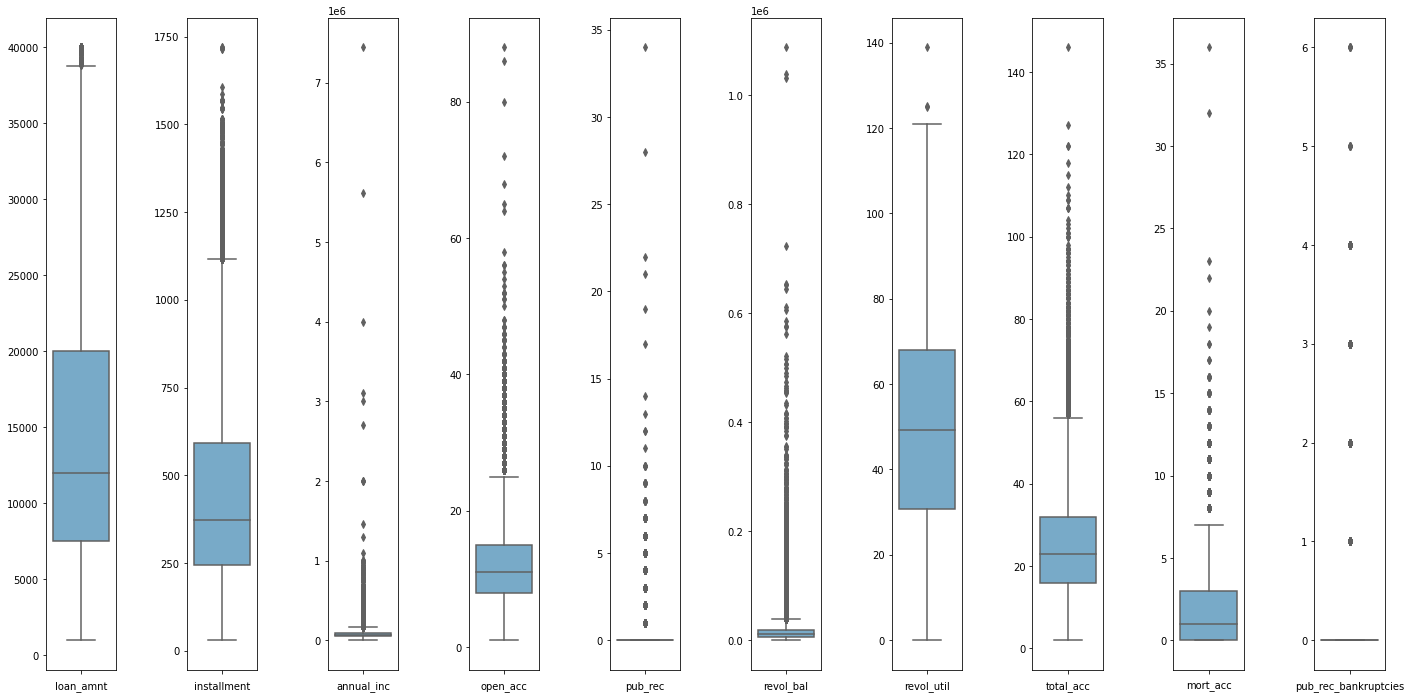

In [17]:
draw_box_plot(df)

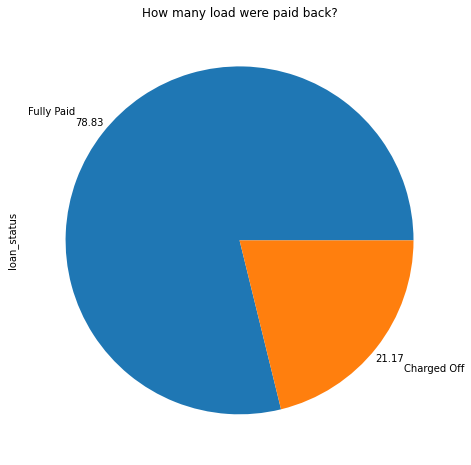

In [18]:
fig = plt.figure(figsize =(8, 8))
df.loan_status.value_counts(normalize=True).plot.pie(autopct='%.2f', 
                                                 pctdistance=1.1, 
                                                 labeldistance=1.2)
plt.title('How many load were paid back?')
plt.show()

## Loan amount 

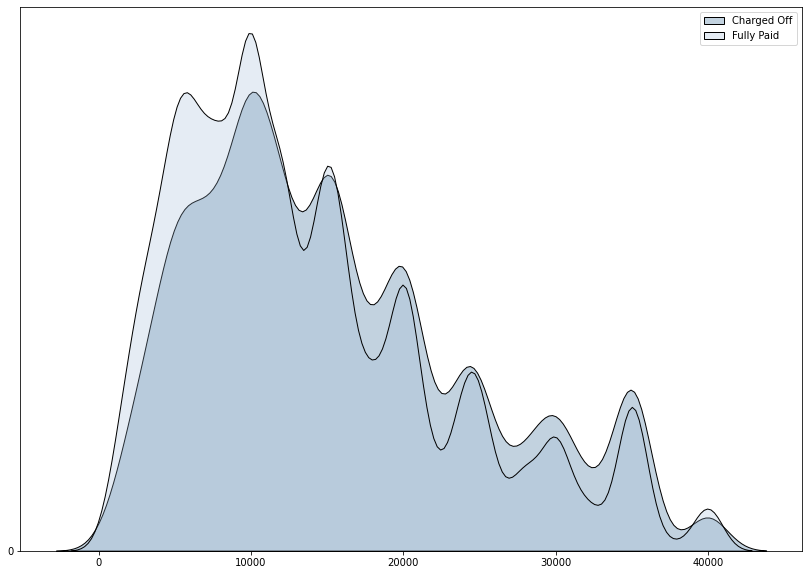

In [19]:
plot_kde('loan_amnt')

Smaller loans tend to be Fully Paid more often

## Loan term

In [20]:
plot_bar(df, 'term')

## Interest rate

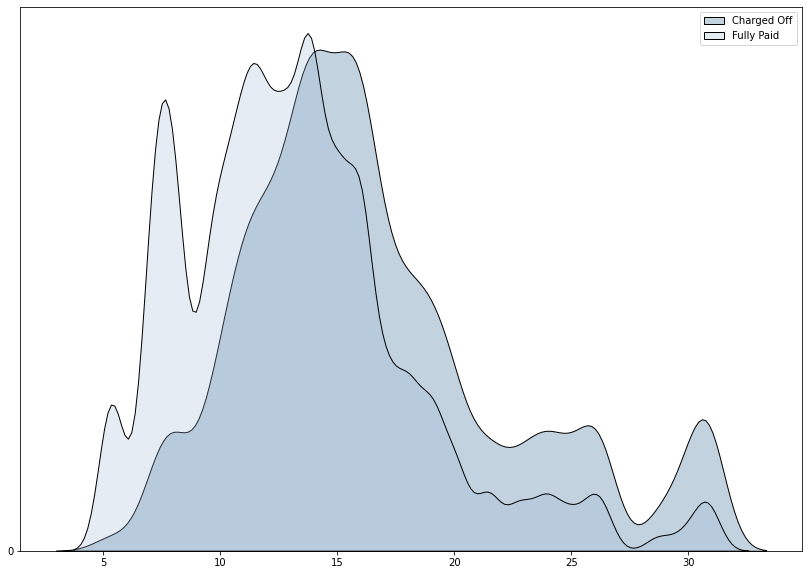

In [21]:
plot_kde('int_rate')

Loans with smaller interest rates tend to be paid more often

## Loan grades

In [22]:
plot_bar(df, 'grade')

The 'larger' the grade of the loan - the bigger the chance of this loan not being paid off. 

## Emplotement lenght

In [23]:
plot_bar(df, 'emp_length')

## Home ownership 

In [24]:
plot_bar(df, 'home_ownership')

## Annual income

In [25]:
bins = (0, 50000, 60000, 70000, 80000, 90000, 100000, 500000, 1000000, 1100000)
labels = ['<50k','<60k', '<70k', '<80k', '<90k', '<100k', '<500k', '<1M', '<11M']
df['level_of_inc'] = pd.cut(x = df['annual_inc'], bins = bins, labels = labels)
df['level_of_inc'].value_counts()

<50k     28151
<500k    20773
<60k     13641
<70k     11841
<80k     10624
<90k      8020
<100k     6823
<1M        114
<11M         2
Name: level_of_inc, dtype: int64

In [26]:
plot_bar(df, 'level_of_inc')

In [27]:
df = df.drop(columns=['level_of_inc'])

## Application type

In [28]:
plot_bar(df, 'application_type')

Interestingly enough, those who have taken a loan on their own, rather than sharing it, seem to have more success in paying it back. 

Or ... those who took Joint Application already had trouble by taking the loan in the first place

## Purpose

In [ ]:
df['purpose'] = df['purpose'].replace({'educational':'other'})
plot_bar(df, 'purpose')

# Feature engeneering: How fast the customer paid back

In [30]:
df['last_pymnt_d']= pd.to_datetime(df['last_pymnt_d'])
df['issue_d']= pd.to_datetime(df['issue_d'])

df['time_paid_back'] = ((df['last_pymnt_d'] - df['issue_d'])/np.timedelta64(1, 'M'))
df = df.drop(columns=['last_pymnt_d', 'issue_d'])

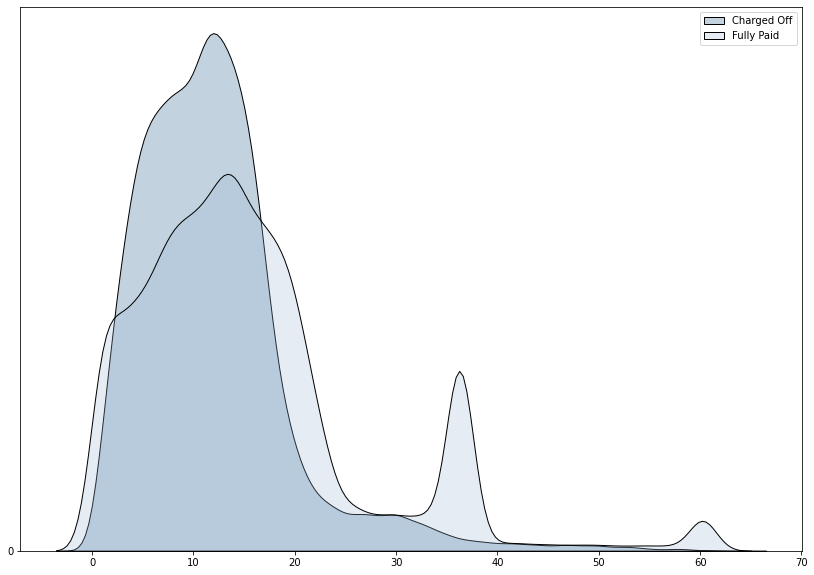

In [31]:
plot_kde('time_paid_back')

We can see a trend here: customers usually fail to pay very early - within the first year. Let me remind you that we have 36 month (3 years) period and 60 months (5 years) period loan term. 

This is visible in this graph too - there is a spike of people concluding their loans right on time - on month 36 and month 60.

## How long customer has a credit account

In [32]:
df['earliest_cr_line']= pd.to_datetime(df['earliest_cr_line'])
df['cr_line'] = ((pd.to_datetime("now") - df['earliest_cr_line'])/np.timedelta64(1, 'Y'))
df = df.drop(columns=['earliest_cr_line'])

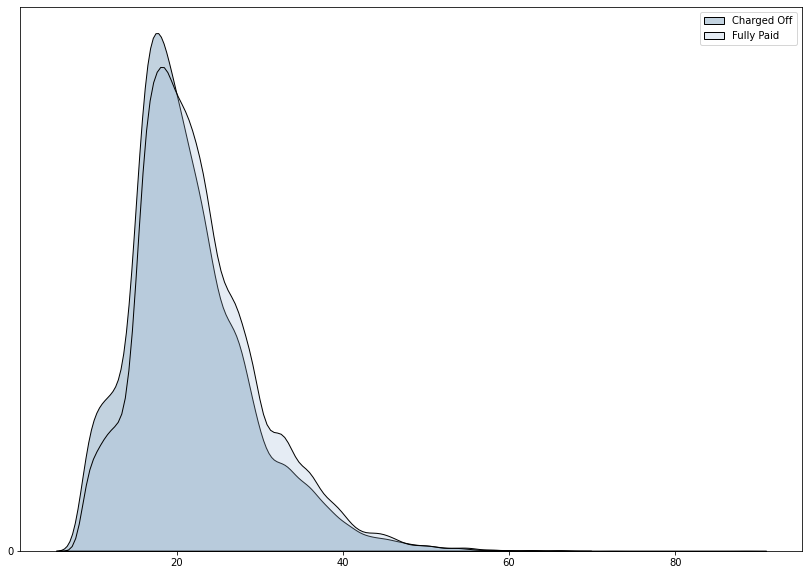

In [33]:
plot_kde('cr_line')

Nothing too interesting here, except that we have customers with credit accounts opened for 50+ years.

# Mapping

In [34]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,loan_status,time_paid_back,cr_line
0,30000.0,36 months,8.24,943.42,B,B1,10+ years,OWN,132630.0,Source Verified,...,3444.0,5.3,22.0,w,Individual,2.0,0.0,Charged Off,23.064129,46.880265
1,7200.0,36 months,28.69,300.51,F,F1,10+ years,MORTGAGE,73000.0,Verified,...,6501.0,28.8,13.0,f,Individual,0.0,1.0,Fully Paid,11.992033,27.465766
2,7000.0,36 months,11.49,230.80,B,B5,9 years,MORTGAGE,60000.0,Not Verified,...,12916.0,54.5,21.0,w,Individual,1.0,0.0,Fully Paid,17.018830,17.716079
3,11200.0,36 months,13.99,382.74,C,C3,3 years,RENT,60000.0,Verified,...,9686.0,40.9,33.0,f,Individual,0.0,0.0,Charged Off,18.037331,18.794815
4,13200.0,36 months,19.99,490.50,D,D4,3 years,RENT,33000.0,Verified,...,9790.0,55.0,30.0,f,Individual,0.0,0.0,Charged Off,10.053595,14.211559


In [35]:
grade_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
df.grade = df.grade.map(grade_mapping)

In [36]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,loan_status,time_paid_back,cr_line
0,30000.0,36 months,8.24,943.42,1,B1,10+ years,OWN,132630.0,Source Verified,...,3444.0,5.3,22.0,w,Individual,2.0,0.0,Charged Off,23.064129,46.880265
1,7200.0,36 months,28.69,300.51,5,F1,10+ years,MORTGAGE,73000.0,Verified,...,6501.0,28.8,13.0,f,Individual,0.0,1.0,Fully Paid,11.992033,27.465766
2,7000.0,36 months,11.49,230.80,1,B5,9 years,MORTGAGE,60000.0,Not Verified,...,12916.0,54.5,21.0,w,Individual,1.0,0.0,Fully Paid,17.018830,17.716079
3,11200.0,36 months,13.99,382.74,2,C3,3 years,RENT,60000.0,Verified,...,9686.0,40.9,33.0,f,Individual,0.0,0.0,Charged Off,18.037331,18.794815
4,13200.0,36 months,19.99,490.50,3,D4,3 years,RENT,33000.0,Verified,...,9790.0,55.0,30.0,f,Individual,0.0,0.0,Charged Off,10.053595,14.211559


In [37]:
sub_grade_mapping = {'A1': 0, 'A2' : 1, 'A3': 2, 'A4': 3, 'A5': 4,
                     'B1': 5, 'B2' : 6, 'B3': 7, 'B4': 8, 'B5': 9,
                     'C1': 10, 'C2' : 11, 'C3': 12, 'C4': 13, 'C5': 14,
                     'D1': 15, 'D2' : 16, 'D3': 17, 'D4': 18, 'D5': 19,
                     'E1': 20, 'E2' : 21, 'E3': 22, 'E4': 23, 'E5': 24,
                     'F1': 25, 'F2' : 26, 'F3': 27, 'F4': 28, 'F5': 29,
                     'G1': 30, 'G2' : 31, 'G3': 32, 'G4': 33, 'G5': 34}
df.sub_grade = df.sub_grade.map(sub_grade_mapping)

In [38]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,loan_status,time_paid_back,cr_line
0,30000.0,36 months,8.24,943.42,1,5,10+ years,OWN,132630.0,Source Verified,...,3444.0,5.3,22.0,w,Individual,2.0,0.0,Charged Off,23.064129,46.880265
1,7200.0,36 months,28.69,300.51,5,25,10+ years,MORTGAGE,73000.0,Verified,...,6501.0,28.8,13.0,f,Individual,0.0,1.0,Fully Paid,11.992033,27.465766
2,7000.0,36 months,11.49,230.80,1,9,9 years,MORTGAGE,60000.0,Not Verified,...,12916.0,54.5,21.0,w,Individual,1.0,0.0,Fully Paid,17.018830,17.716079
3,11200.0,36 months,13.99,382.74,2,12,3 years,RENT,60000.0,Verified,...,9686.0,40.9,33.0,f,Individual,0.0,0.0,Charged Off,18.037331,18.794815
4,13200.0,36 months,19.99,490.50,3,18,3 years,RENT,33000.0,Verified,...,9790.0,55.0,30.0,f,Individual,0.0,0.0,Charged Off,10.053595,14.211559


In [39]:
employ_mapping = {'< 1 year': 0, 
                  '1 year': 1,
                  '2 years' : 2,
                  '3 years' : 3,
                  '4 years' : 4,
                  '5 years' : 5,
                  '6 years' : 6,
                  '7 years' : 7,
                  '8 years' : 8,
                  '9 years' : 9,
                  '10+ years' : 10}
df.emp_length = df.emp_length.map(employ_mapping)

In [40]:
purpose_mapping = {'debt_consolidation': 0, 
                  'credit_card': 1,
                  'home_improvement': 2,
                  'other': 3,
                  'major_purchase': 4,
                  'car': 5,
                  'vacation': 6,
                  'moving': 7,
                  'house': 8,
                  'renewable_energy': 9,
                  'wedding': 10,
                  'medical': 11,
                  'small_business': 12}

df.purpose = df.purpose.map(lambda x: purpose_mapping.get(x,x))

In [41]:
loan_status_mapping = {'Charged Off': 0, 
                  'Fully Paid': 1}
df.loan_status = df.loan_status.map(loan_status_mapping)


In [42]:
categ = ['term', 'home_ownership', 'initial_list_status', 'application_type', 'verification_status']

le = LabelEncoder()
df[categ] = df[categ].apply(le.fit_transform)

# Hypotesis testing

A few points were not so clear to me.
* Is there really significant difference between 'Individual' loans and 'Joint Application Loans'? 
* Is employement lenght affecting the final outcome of the loan?



H0 => µ1 = µ2 (population mean of dataset1 is equal to dataset2)

HA => µ1 ≠µ2 (population mean of dataset1 is different from dataset2)


In [52]:
stats.ttest_ind(df['emp_length'][df['loan_status'] == 1],
                df['emp_length'][df['loan_status'] == 0])

Ttest_indResult(statistic=11.255982251040646, pvalue=2.2539711968395243e-29)

In [53]:
stats.ttest_ind(df['application_type'][df['loan_status'] == 1],
                df['application_type'][df['loan_status'] == 0])

Ttest_indResult(statistic=-6.935300707857561, pvalue=4.07805671802054e-12)

In [54]:
stats.ttest_ind(df['cr_line'][df['loan_status'] == 1],
                df['cr_line'][df['loan_status'] == 0])

Ttest_indResult(statistic=18.47791131091476, pvalue=4.166499896737837e-76)

All the above-tested features are significant, loan status is influenced by employment length, application type, and how long a person has its credit opened.

# Correlations

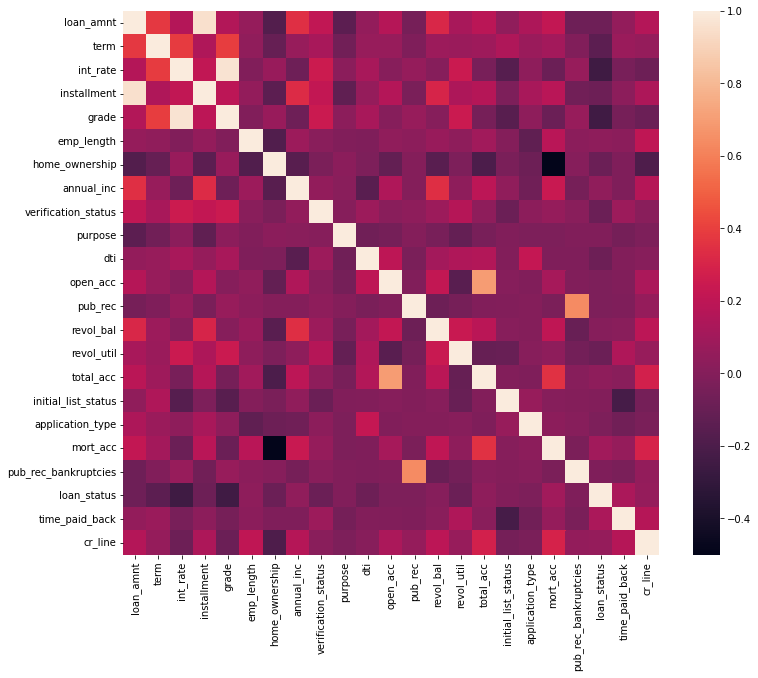

In [43]:
fig = plt.figure(figsize= (12, 10))
corr = df.drop(['sub_grade'], axis=1).corr()
sns.heatmap(corr)
plt.show()

Although there is an indication of a higher correlation in the up left part of the graph when compared to the rest, the highest values were encountered for int_rate x grade and home_ownership x mort_acc. and few others.

Therefore, we will be dropping home_ownership, total_acc, pub_rec from the features list that served as input to the models.

In [45]:
corr_matrix = df.corr()
print(corr_matrix["grade"].sort_values(ascending=False))

grade                   1.000000
sub_grade               0.974837
int_rate                0.966002
term                    0.393655
verification_status     0.245969
revol_util              0.244759
installment             0.195989
loan_amnt               0.159269
dti                     0.122329
home_ownership          0.070033
pub_rec_bankruptcies    0.064274
pub_rec                 0.062851
application_type        0.034467
purpose                 0.029790
open_acc                0.009049
revol_bal               0.005680
emp_length             -0.009391
time_paid_back         -0.045442
total_acc              -0.046104
annual_inc             -0.074626
cr_line                -0.087056
mort_acc               -0.089302
initial_list_status    -0.158641
loan_status            -0.247766
Name: grade, dtype: float64


In [46]:
df = df.drop(columns=['installment', 'total_acc', 'pub_rec'])

# OPTUNA for loan_status

Let's leave the hyper-tuning to OPTUNA - an automatic hyperparameter optimization software framework.

In [47]:
X = df.drop(['loan_status'], axis=1)
y = df[['loan_status']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, 
                                                  shuffle=False,
                                                  random_state=0)



smtom = SMOTETomek(random_state=42)
X_train, y_train = smtom.fit_resample(X_train, y_train)

In [48]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(lambda trial: classification(trial), n_trials= 100)

[I 2022-11-17 16:01:46,383] A new study created in memory with name: no-name-58c91687-73b4-4596-be24-7befcbef0ac9
[I 2022-11-17 16:01:49,329] Trial 0 finished with value: 0.6200636417352684 and parameters: {'booster': 'gblinear', 'lambda': 0.0006155564318973012, 'alpha': 1.77071686435378e-07, 'subsample': 0.32479561626896214, 'colsample_bytree': 0.24646688973455957}. Best is trial 0 with value: 0.6200636417352684.
[I 2022-11-17 16:01:59,936] Trial 1 finished with value: 0.6617977196311108 and parameters: {'booster': 'gbtree', 'lambda': 1.4610865886287176e-08, 'alpha': 0.574485163632042, 'subsample': 0.8659541126403374, 'colsample_bytree': 0.36987128854262097, 'max_depth': 3, 'min_child_weight': 3, 'eta': 2.716051144654844e-06, 'gamma': 0.00015777981883364995, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.6617977196311108.
[I 2022-11-17 16:02:17,390] Trial 2 finished with value: 0.6452250527280088 and parameters: {'booster': 'gbtree', 'lambda': 8.528933855762793e-06, 'alpha

In [49]:
Best_trial = study.best_trial.params
Optuna_XGB_model = XGBClassifier(**Best_trial)
fitted_model = Optuna_XGB_model.fit(X_train, y_train)
optuna_pred = Optuna_XGB_model.predict(X_val)

In [50]:
fitted_model.save_model('xgb_model_optuna.json')

In [100]:
evaluation(optuna_pred)


 R-Squared :  -108.48985165978876

 ROC AUC Score :  0.6532061558618633

 Model Accuracy :  0.65928
              precision    recall  f1-score   support

           0       0.33      0.64      0.44      5144
           1       0.88      0.66      0.76     19856

    accuracy                           0.66     25000
   macro avg       0.60      0.65      0.60     25000
weighted avg       0.77      0.66      0.69     25000



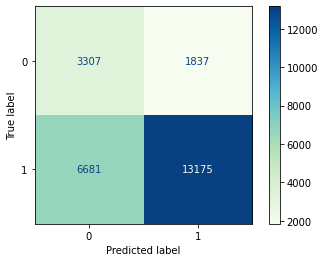

In [51]:
confusion_matrix = metrics.plot_confusion_matrix(Optuna_XGB_model, X_val, y_val, cmap = 'GnBu')
confusion_matrix

## Learning more about the model

In [54]:
explainer = shap.TreeExplainer(fitted_model)
shap_values = explainer.shap_values(X_train)

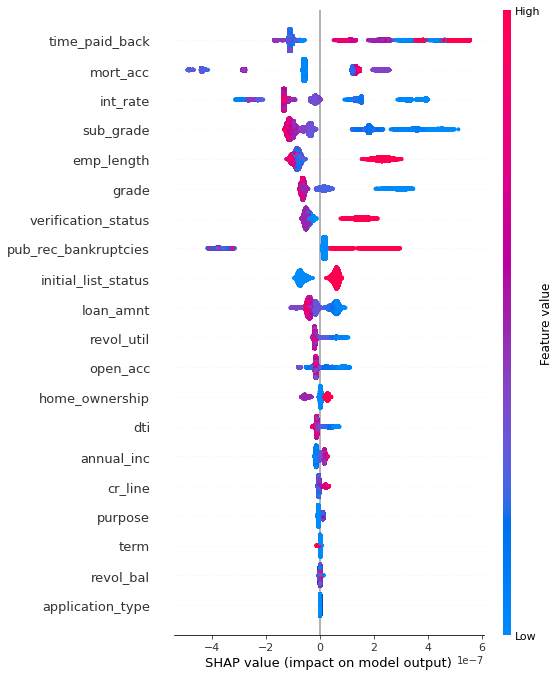

In [55]:
shap.initjs()
shap.summary_plot(shap_values, X_train)

We can see that we did a great job creating time_paid_back feature - it's the one influencing our model the most. We can also see that the model recognized the trends too (switching between blue and pink).

Mortgage accounts are influential too, if people already paying for their house, they more likely to run into financial struggles and not pay us back.

Although we saw the difference in application_type, it does not mean much for our model. The same can be said about the term revolving balance.

# OPTUNA for grade

In [56]:
X = df.drop(['loan_status', 'sub_grade', 'grade'], axis=1)
y = df[['grade']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, 
                                                  shuffle=False,
                                                  random_state=0)

smtom = SMOTETomek(random_state=42)
X_train, y_train = smtom.fit_resample(X_train, y_train)

In [57]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(lambda trial: classification_multi(trial), n_trials= 10)

[I 2022-11-17 16:31:26,013] A new study created in memory with name: no-name-953a8038-8225-4bfd-890e-b845c8cb54f3
[I 2022-11-17 16:31:47,857] Trial 0 finished with value: 0.8851803270195696 and parameters: {'booster': 'gblinear', 'lambda': 0.0006155564318973012, 'alpha': 1.77071686435378e-07, 'subsample': 0.32479561626896214, 'colsample_bytree': 0.24646688973455957}. Best is trial 0 with value: 0.8851803270195696.
[I 2022-11-17 16:32:38,204] Trial 1 finished with value: 0.9948373775886237 and parameters: {'booster': 'gbtree', 'lambda': 1.4610865886287176e-08, 'alpha': 0.574485163632042, 'subsample': 0.8659541126403374, 'colsample_bytree': 0.36987128854262097, 'max_depth': 3, 'min_child_weight': 3, 'eta': 2.716051144654844e-06, 'gamma': 0.00015777981883364995, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.9948373775886237.
[I 2022-11-17 16:34:27,314] Trial 2 finished with value: 0.9977013070657081 and parameters: {'booster': 'gbtree', 'lambda': 8.528933855762793e-06, 'alpha

In [58]:
Best_trial = study.best_trial.params
Optuna_XGB_model = XGBClassifier(**Best_trial)
fitted_model = Optuna_XGB_model.fit(X_train, y_train)
optuna_pred = Optuna_XGB_model.predict(X_val)

In [59]:
fitted_model.save_model('xgb_model_grade_optuna.json')

In [60]:
evaluation_multi(optuna_pred)


 R-Squared :  99.22696053382111

 ROC AUC Score :  0.9957698474360254

 Model Accuracy :  0.9922
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4037
           1       1.00      1.00      1.00      6969
           2       1.00      1.00      1.00      8097
           3       0.99      1.00      0.99      3485
           4       0.93      0.98      0.96      1518
           5       1.00      0.82      0.90       464
           6       1.00      0.94      0.97       430

    accuracy                           0.99     25000
   macro avg       0.99      0.96      0.97     25000
weighted avg       0.99      0.99      0.99     25000



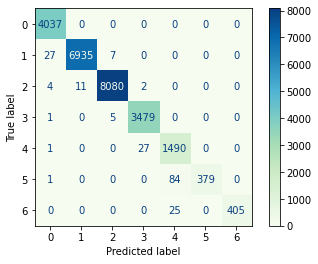

In [61]:
confusion_matrix = metrics.plot_confusion_matrix(Optuna_XGB_model, X_val, y_val, cmap = 'GnBu')
confusion_matrix

In [62]:
explainer = shap.TreeExplainer(fitted_model)
shap_values = explainer.shap_values(X_train)

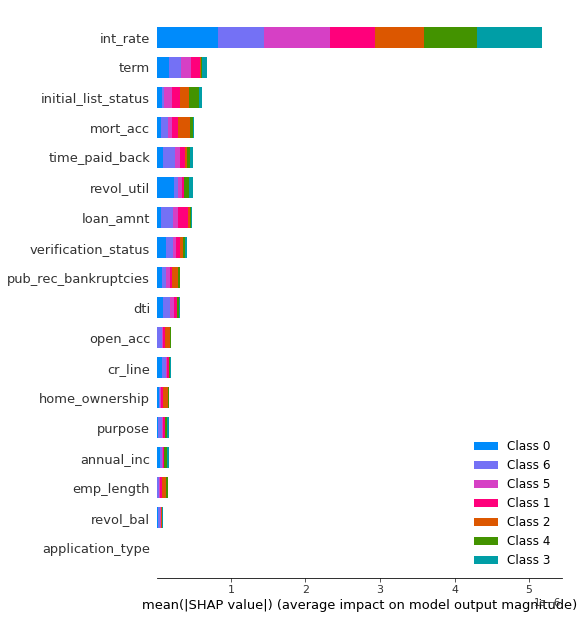

In [63]:
shap.initjs()
shap.summary_plot(shap_values, X_train)

# sub_grade x int_rate prediction with HistGradientBoostingRegressor

In [65]:
!pip install scikit-learn
import sklearn
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn import ensemble
from sklearn.multioutput import MultiOutputRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
X = df.drop(['loan_status', 'sub_grade', 'int_rate'], axis=1)
y = df[['sub_grade', 'int_rate']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, 
                                                  random_state=0,
                                                  shuffle = False)

In [67]:
params = {'max_depth': 15, 
          'max_leaf_nodes': 100, 
          'verbose': True,
          'random_state': 42, 
          'max_iter': 10}

sub_grade_model = MultiOutputRegressor(ensemble.HistGradientBoostingRegressor(**params))
sub_grade_model.fit(X_train, y_train)

Binning 0.010 GB of training data: 0.179 s
Binning 0.001 GB of validation data: 0.007 s
Fitting gradient boosted rounds:
[1/10] 1 tree, 100 leaves, max depth = 12, train loss: 16.84757, val loss: 16.12673, in 0.067s
[2/10] 1 tree, 100 leaves, max depth = 11, train loss: 13.82944, val loss: 13.25125, in 0.066s
[3/10] 1 tree, 100 leaves, max depth = 12, train loss: 11.38435, val loss: 10.91908, in 0.040s
[4/10] 1 tree, 100 leaves, max depth = 12, train loss: 9.40333, val loss: 9.02969, in 0.042s
[5/10] 1 tree, 100 leaves, max depth = 12, train loss: 7.79821, val loss: 7.49841, in 0.038s
[6/10] 1 tree, 100 leaves, max depth = 12, train loss: 6.49774, val loss: 6.25870, in 0.044s
[7/10] 1 tree, 100 leaves, max depth = 13, train loss: 5.44366, val loss: 5.25282, in 0.050s
[8/10] 1 tree, 100 leaves, max depth = 12, train loss: 4.58941, val loss: 4.43872, in 0.058s
[9/10] 1 tree, 100 leaves, max depth = 13, train loss: 3.89708, val loss: 3.77825, in 0.041s
[10/10] 1 tree, 100 leaves, max dept

MultiOutputRegressor(estimator=HistGradientBoostingRegressor(max_depth=15,
                                                             max_iter=10,
                                                             max_leaf_nodes=100,
                                                             random_state=42,
                                                             verbose=True))

In [68]:
sub_grade_model.score(X_val, y_val)

0.8317113679530925

In [69]:
preds = sub_grade_model.predict(X_val)


In [70]:
mse = mean_squared_error(y_val, sub_grade_model.predict(X_val))
mse

6.2503006081943955

In [71]:
import pickle
filename = 'sub_grade.sav'
pickle.dump(sub_grade_model, open(filename, 'wb'))

# Streamlit

To see deployed models please continue with this link:

* Streamlit App https://gaci-git-loan-club-streamlit-51xmir.streamlit.app

* My github repository: https://github.com/Gaci-git/loan_club



# Conclusion

We successfully build very simple models that can take some details from our customer's bio and credit info, created a few parameters ourselves (how long it is taking to repay, and how long the customer has it's credit account opened), and now can predict loan outcome, loan grade and a combination of loan subgrade and interest rate.   

Having an easy-to-interpret model that a loan officer can use to provide immediate estimates can not only speed up the process but also save lenders from potential losses.